In [92]:
# librarires ---- 

import pandas as pd
import numpy as np
import yfinance as yf
from prettytable import PrettyTable
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# basic functions ----

def load_data(ticker_name, start_date):
    return yf.download(ticker_name, start_date)

    
# investment

def annual_return(ticker_name, start_date):
    data = load_data(ticker_name, start_date)
    data['total_returns'] = data['Adj Close'].pct_change()
    annual_return = data.total_returns.mean()*252*100
    return round(annual_return, 1)
    
def annual_volatility(ticker_name, start_date):
    data = load_data(ticker_name, start_date)
    data['total_returns'] = data['Adj Close'].pct_change()
    annual_volatility = data.total_returns.std() * np.sqrt(252) * 100
    return round(annual_volatility, 1)

def vis_close_price(ticker_name, start_date):
    data = load_data(ticker_name, start_date)
    data['Close'].plot(figsize=(15,7))
    plt.ylabel('Close Price')
    plt.title('{} Close Price'.format(ticker_name))
    plt.show()

# swing trading

def calc_trade_returns(ticker_name, start_date, model):
    data = model(ticker_name, start_date)
    data['returns'] = data.Close.pct_change()
    data['trade_returns'] = data.returns * data.trading_signal.shift(1)
    return data

def trade_return(ticker_name, start_date):
    cumulative_trade_returns = (data.trade_returns + 1).cumprod()
    days = len(cumulative_trade_returns)
    annual_returns = (cumulative_trade_returns.iloc[-1]**(252/days) - 1)*100
    return round(annual_returns, 1)

def trade_volatility(ticker_name, start_date):
    annual_volatility = data.trade_returns.std() * np.sqrt(252) * 100
    return round(annual_volatility, 1)
    

def vis_trade_return(ticker_name, start_date, model):
    cumulative_trade_returns = (data.trade_returns + 1).cumprod()
    cumulative_trade_returns.plot(figsize=(15,7))
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns of {} Strategy on {}'.format(model.__name__, ticker_name))
    plt.show()
    
    
# summary ----

def sum_table(ticker_name, start_date, model_lst):
    # create table with columns
    myTable = pd.DataFrame(columns = ["Strategy", "Annualized Return (%)", "Annualized Volatility (%)"])
    
    # add first row (investment) 
    myTable = myTable.append(
        pd.DataFrame(
            [["Investment", annual_return(ticker_name, start_date), annual_volatility(ticker_name, start_date)]],
            columns = ["Strategy", "Annualized Return (%)", "Annualized Volatility (%)"],
        ), ignore_index = True)
    
    # add the rest of the strategies as rows
    global data
    for i, model in enumerate(model_lst):
        data = calc_trade_returns(ticker_name, start_date, model)
        myTable = myTable.append(
            pd.DataFrame(
                [[model.__name__, trade_return(ticker_name, start_date), trade_volatility(ticker_name, start_date)]],
                columns = ["Strategy", "Annualized Return (%)", "Annualized Volatility (%)"],
                ), ignore_index = True)
    return myTable

def sum_vis(ticker_name, start_date, model_lst):
    # visualize the investment strategy
    vis_close_price(ticker_name, start_date)
    
    # visualize the rest of the strategies
    global data
    for i, model in enumerate(model_lst):
        data = calc_trade_returns(ticker_name, start_date, model)
        vis_trade_return(ticker_name, start_date, model)
        
    
def efficient_front(ticker_name, start_date, model_lst):
    # load sum_table
    myTable = sum_table(ticker_name, start_date, model_lst)
    # plot
    plt.figure(figsize=(15, 7))
    plt.scatter(myTable['Annualized Volatility (%)'], myTable['Annualized Return (%)'])
    plt.xlabel('Annualized Volatility (%)')
    plt.ylabel('Annualized Return (%)')
    plt.title('Efficient Frontier')
    # annotate points
    for i, label in enumerate(myTable['Strategy']):
        plt.annotate(label, (myTable['Annualized Volatility (%)'][i], myTable['Annualized Return (%)'][i]))
    plt.show()
    

    
# models ----

def MACD(ticker_name, start_date):
    data = load_data(ticker_name, start_date)
    data['12d_EMA'] = data.Close.ewm(span=12, adjust=False).mean()
    data['26d_EMA'] = data.Close.ewm(span=26, adjust=False).mean()
    data['macd'] = data['12d_EMA']- data['26d_EMA'] 
    data['macdsignal'] = data.macd.ewm(span=9, adjust=False).mean()
    data['trading_signal'] = np.nan
    data.loc[data['macd'] > data['macdsignal'], 'trading_signal'] = 1
    data.loc[data['macd'] < data['macdsignal'], 'trading_signal'] = -1
    data = data.fillna(method = 'ffill')
    return data

def SMA(ticker_name, start_date):
    data = load_data(ticker_name, start_date)
    data['10d_SMA'] = data.Close.rolling(window=10).mean()
    data['50d_SMA'] = data.Close.rolling(window=50).mean()
    data['trading_signal'] = np.nan
    data.loc[data['10d_SMA'] > data['50d_SMA'], 'trading_signal'] = 1
    data.loc[data['10d_SMA'] < data['50d_SMA'], 'trading_signal'] = -1
    data = data.fillna(method = 'ffill')
    return data

def calc_RSI (data, time_window=14):
    diff = data.diff(1).dropna()       
    up_chg = 0 * diff
    down_chg = 0 * diff
    up_chg[diff > 0] = diff[diff>0]
    down_chg[diff < 0] = diff[diff < 0]
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi
    return RSI

def RSI(ticker_name, start_date, window=14):
    data = load_data(ticker_name, start_date)
    data['RSI'] = calc_RSI(data['Adj Close'], 14)
    data['trading_signal'] = np.nan
    data.loc[data['RSI'] < 30, 'trading_signal'] = 1
    data.loc[data['RSI'] > 70, 'trading_signal'] = -1
    data = data.fillna(method = 'ffill')
    return data

# def Andre(ticker_name, start_date):
#     data = load_data(ticker_name, start_date)
#     data['50d_SMA'] = data.Close.rolling(window=50).mean()
#     data['100d_SMA'] = data.Close.rolling(window=100).mean()
#     data['trading_signal'] = np.nan
#     data.loc[data['Close'] < data['50d_SMA'], 'trading_signal'] = -1
#     data.loc[data['Close'] < data['100d_SMA'], 'trading_signal'] = -5
#     data.at[len(data['Close']),'Close'] = sum(data['trading_signal'])
#     data = data.fillna(method = 'ffill')
#     return data


In [94]:
sum_table('WMT', '2017-12-23', [MACD, SMA, RSI])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/var/folders/h5/nb6dpjws5_31tkqzms_p18gr0000gn/T/ipykernel_9673/1933514332.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myTable = myTable.append(


[*********************100%***********************]  1 of 1 completed


/var/folders/h5/nb6dpjws5_31tkqzms_p18gr0000gn/T/ipykernel_9673/1933514332.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myTable = myTable.append(


[*********************100%***********************]  1 of 1 completed


/var/folders/h5/nb6dpjws5_31tkqzms_p18gr0000gn/T/ipykernel_9673/1933514332.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myTable = myTable.append(


[*********************100%***********************]  1 of 1 completed


/var/folders/h5/nb6dpjws5_31tkqzms_p18gr0000gn/T/ipykernel_9673/1933514332.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myTable = myTable.append(


,Strategy,Annualized Return (%),Annualized Volatility (%)
0,Investment,12.0,23.5
1,MACD,4.1,23.5
2,SMA,-6.7,23.2
3,RSI,35.0,23.5


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/var/folders/h5/nb6dpjws5_31tkqzms_p18gr0000gn/T/ipykernel_9673/1933514332.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myTable = myTable.append(


[*********************100%***********************]  1 of 1 completed


/var/folders/h5/nb6dpjws5_31tkqzms_p18gr0000gn/T/ipykernel_9673/1933514332.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myTable = myTable.append(


[*********************100%***********************]  1 of 1 completed


/var/folders/h5/nb6dpjws5_31tkqzms_p18gr0000gn/T/ipykernel_9673/1933514332.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myTable = myTable.append(


[*********************100%***********************]  1 of 1 completed


/var/folders/h5/nb6dpjws5_31tkqzms_p18gr0000gn/T/ipykernel_9673/1933514332.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myTable = myTable.append(


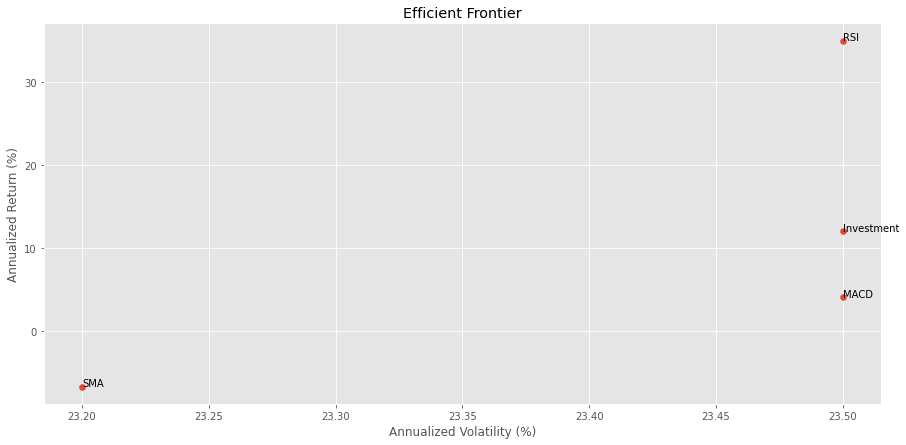

In [93]:
efficient_front('WMT', '2017-12-23', [MACD, SMA, RSI])

[*********************100%***********************]  1 of 1 completed


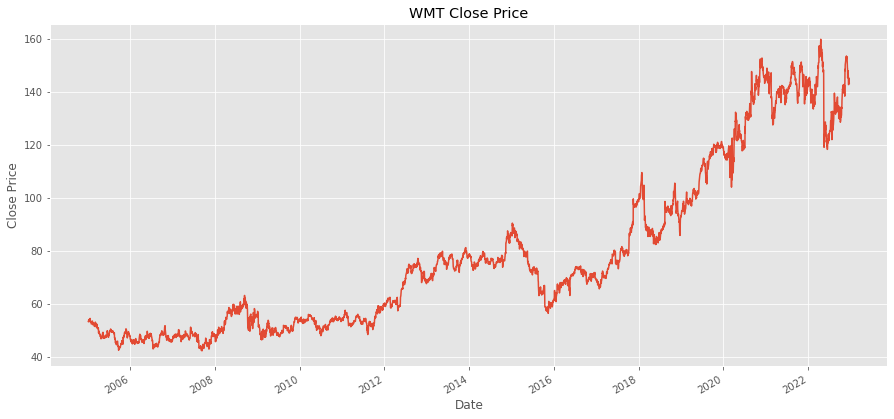

[*********************100%***********************]  1 of 1 completed


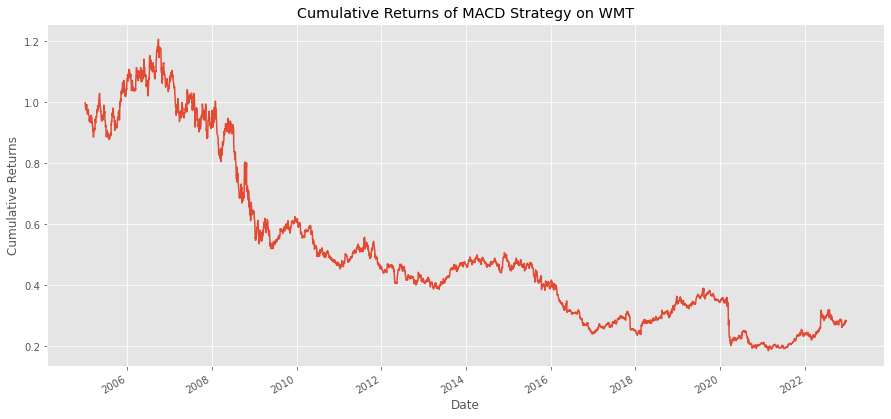

[*********************100%***********************]  1 of 1 completed


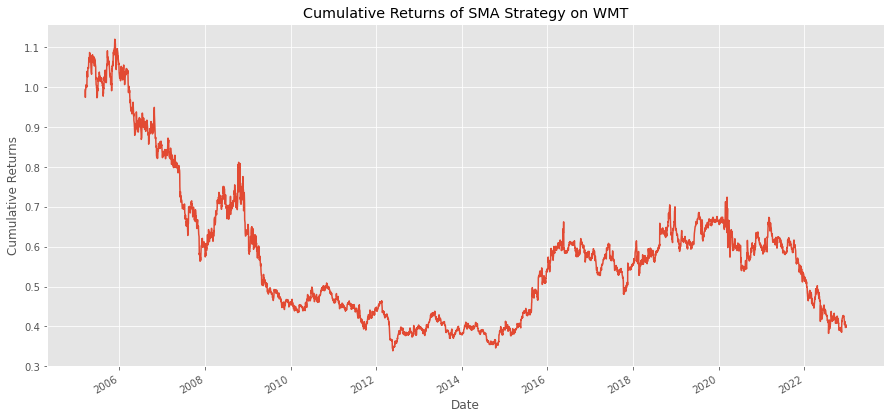

[*********************100%***********************]  1 of 1 completed


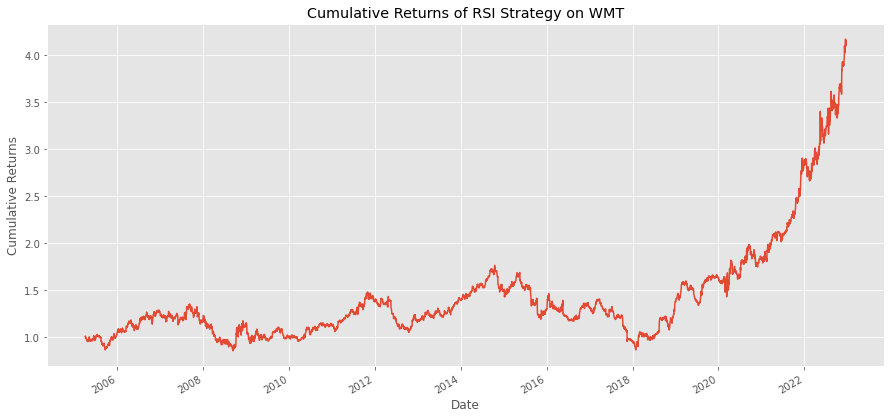

In [95]:
sum_vis('WMT', '2005-1-1', [MACD, SMA, RSI])